# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


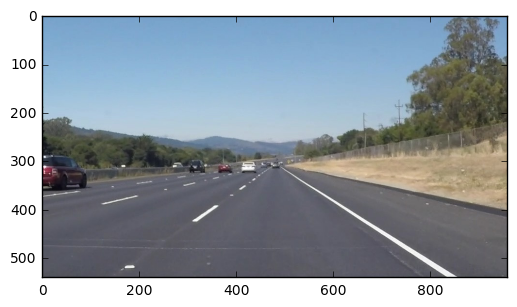

In [2]:
# your project directory
directory = '/Users/sitaraassomull/Code/Algos/CarND-LaneLines-P1/'

#reading in an image
image = mpimg.imread(directory + 'test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## More Helper Methods
These methods help to filters relevant lines and average and extrapolate the lane lines

In [4]:
def get_slope(line):
    """ Calculates and returns the slope of a line """
    for x1, y1, x2, y2 in line:
        return (y1 - y2) / (x1 - x2)


def get_line_size(line):
    """ Calculates and returns the size in pixels of a line"""
    for x1, y1, x2, y2 in line:
        return math.hypot(x2 - x1, y2 - y1)


def divide_lines(lines):
    """ Divides the relevant hough lines into left & right sections and ignores the noise"""
    right_lines = []
    left_lines = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = get_slope(line)
            if slope > 0.5:
                right_lines.append([x1, y1, x2, y2, slope])
            if slope < -0.5:
                left_lines.append([x1, y1, x2, y2, slope])

    return right_lines, left_lines

def moving_average(previous_avg, new_position, N=20):
    """ Calculates the moving average of a co-ordinate of a line"""
    if (previous_avg == 0):
        return new_position
    previous_avg -= previous_avg / N;
    previous_avg += new_position / N;
    return previous_avg;


def extend_line(x1, y1, x2, y2, length):
    """ Takes line endpoints and extroplates new endpoint by a specfic length"""
    line_len = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    x = x2 + (x2 - x1) / line_len * length
    y = y2 + (y2 - y1) / line_len * length
    return int(x), int(y)


def draw_right_lane_line(img, right_lines):
        
    global avg_top_right_x
    global avg_top_right_y
    global avg_bottom_right_x
    global avg_bottom_right_y

    x1 = moving_average(avg_top_right_x, int(np.mean(right_lines, axis=0)[0]))
    y1 = moving_average(avg_top_right_y, int(np.mean(right_lines, axis=0)[1]))
    x2 = moving_average(avg_bottom_right_x, int(np.mean(right_lines, axis=0)[2]))
    y2 = moving_average(avg_bottom_right_y, int(np.mean(right_lines, axis=0)[3]))

    avg_top_right_x = x1
    avg_top_right_y = y1
    avg_bottom_right_x = x2
    avg_bottom_right_y = y2

    x1, y1 = extend_line(x1, y1, x2, y2, -1000)
    x2, y2 = extend_line(x1, y1, x2, y2, 1000)

    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 10)


def draw_left_lane_line(img, left_lines):
    
    global avg_top_left_x
    global avg_top_left_y
    global avg_bottom_left_x
    global avg_bottom_left_y

    x1 = moving_average(avg_top_left_x, int(np.mean(left_lines, axis=0)[0]))
    y1 = moving_average(avg_top_left_y, int(np.mean(left_lines, axis=0)[1]))
    x2 = moving_average(avg_bottom_left_x, int(np.mean(left_lines, axis=0)[2]))
    y2 = moving_average(avg_bottom_left_y, int(np.mean(left_lines, axis=0)[3]))

    avg_top_left_x = x1
    avg_top_left_y = y1
    avg_bottom_left_x = x2
    avg_bottom_left_y = y2

    x1, y1 = extend_line(x1, y1, x2, y2, -1000)
    x2, y2 = extend_line(x1, y1, x2, y2, 1000)

    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 10)


def draw_lane_lines(img, lines):
    right_lines, left_lines = divide_lines(lines)
    draw_left_lane_line(img, left_lines)
    draw_right_lane_line(img, right_lines)

In [5]:
def process_image(image, debug='false'):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image where lines are drawn on lanes)
    imshape = image.shape

    gray = grayscale(image)

    blurred_mage = gaussian_blur(gray, kernel_size=7)

    img_with_canny_edges = canny(blurred_mage, 50, 150)

    vertices = np.array([[(0, imshape[0]), (465, 320), (475, 320), (imshape[1], imshape[0])]], dtype=np.int32)

    polygon = region_of_interest(img_with_canny_edges, vertices)

    # Hough lines
    rho = 2  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 30  # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40  # minimum number of pixels making up a line
    max_line_gap = 200  # maximum gap in pixels between connectable line segments
    lines = hough_lines(polygon, rho, theta, threshold, min_line_len, max_line_gap)

    vertices = np.array([[(0, imshape[0]), (200, 320), (800, 320), (imshape[1], imshape[0])]], dtype=np.int32)
    lines = region_of_interest(lines, vertices)

    if debug == 'true':

        plt.subplot(2,2,1)
        plt.imshow(image)

        plt.subplot(2,2,2)
        plt.imshow(blurred_mage, cmap="gray")

        plt.subplot(2,2,3)
        plt.imshow(img_with_canny_edges, cmap="gray")

        plt.subplot(2,2,4)
        plt.imshow(lines, cmap="gray")

        plt.show()


    result = weighted_img(lines, image)

    return result

In [6]:
import os

# Quick method to see list of files in a directory as array
os.listdir(directory + "test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Test on Images

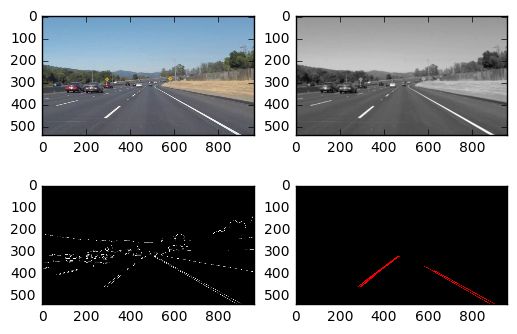

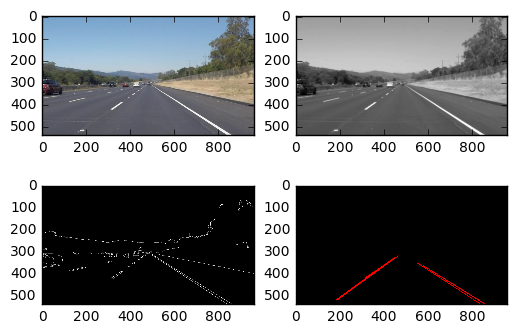

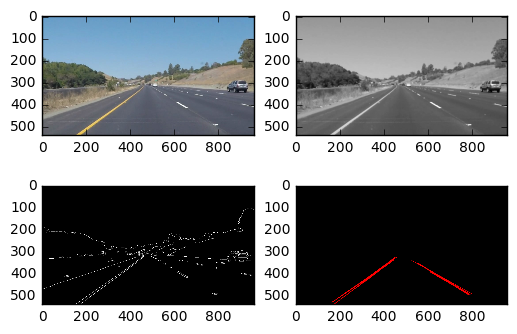

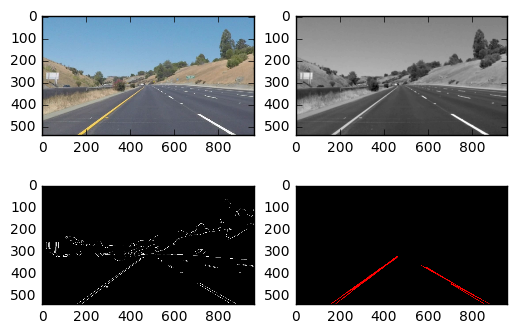

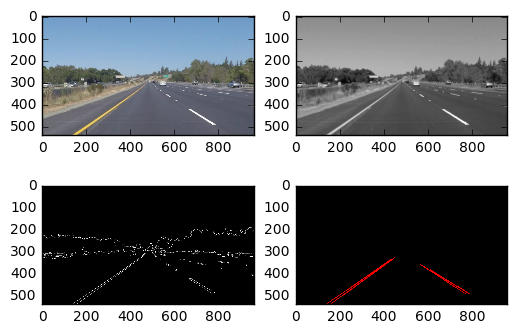

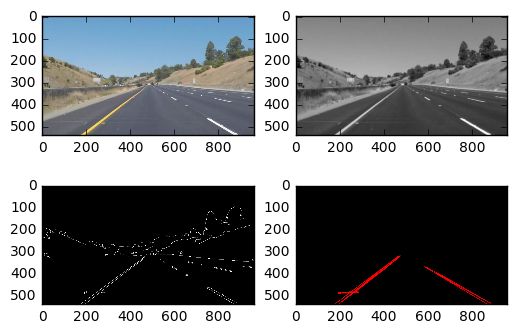

In [7]:
for img in os.listdir(directory + 'test_images/'):
    test_image = mpimg.imread(directory + 'test_images/' + img)
    process_image(test_image, debug='true')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
white_output = directory + 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip(directory + "test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = directory + 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip(directory + 'test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Pipleline Explanation
1. First we turn the color image into grayscale using the grayscale method. This helps to reduce the calculations as now
we have to deal with just one colour instead of three(RGB).
2. Next we want to remove the noise i.e. the random pixelation in the image using gaussian_blur method. 
3. Now with the smooth image, we will apply canny edge detector on the image. The output will be an image with edges on it. Edges are basically areas in the image where there is a sharp change in the color.
4. Now, we will select a region from the image in which we are interested. As in order to find the lanes, we only need to focus on the road we will just select the region that covers the roads. 
5. From the region of interest, now we can look for edges that appear to be a line using hough_transform. This method returns an array of co-ordinates of lines that it detects in the image. 
6. From the line co-ordinates returned from hough transform, we will take the moving avergage the co-ordinates, extend the lines and then plot them over the image.
7. Then we return the combined image of the output and input and return it using weighted_img method.

# Reflections
1. Colors: It's difficult to account for colors in this process, specially detecting yellow lines
2. Shaky lines: Taking the moving average of the lines help to remove the shakiness of the lines, but on sharp turn, our detection might fall behind then the actual, lanes. 
3. Region Of Interest: In some situations we may need to extend our region of interest which can be a challenge
4. Noise: Smoothing the image helps but there still can be situtations where the lane detection can fail.
5. No lanes: Of course, our alogrithm will fail if suddenly the road has no lane marking or only one lane marking, make an algorithm to take all situtations into account will be a challenging task

